# Homework 4 - Image Processing

## Data Preparation


In [1]:
using Statistics, StatsBase
using MultivariateStats
using Plots
using TestImages
using Distances 
#theme(:dark)

In [2]:
using GaussianMixtures
using ScikitLearn
using ScikitLearn: fit!
using Suppressor

In [3]:
using Clustering
using Random
using ImageSegmentation

In [4]:
@sk_import cluster: (MeanShift, estimate_bandwidth);

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = import_sklearn() at Skcore.jl:120
└ @ ScikitLearn.Skcore /home/zach/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:120
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at Skcore.jl:158
└ @ Core /home/zach/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:158
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at Skcore.jl:158
└ @ Core /home/zach/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:158


In [5]:
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end

get_random_color (generic function with 1 method)

In [6]:
function labels_to_color_image(labels, width, height)
    colors = map(i->get_random_color(i), labels);
    display(reshape(colors, width, height)')
end

labels_to_color_image (generic function with 1 method)

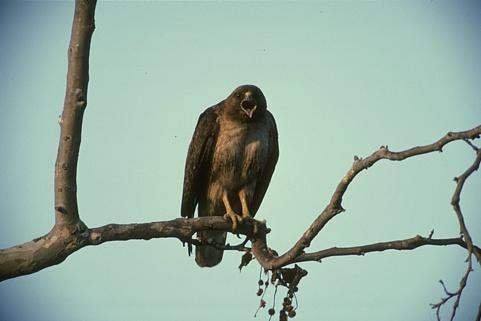

In [7]:
using Images
data = load("42049_colorBird.jpg")

In [8]:
nr,nc = size(data)[1], size(data)[2];
featureSize = nc*nr;
raw_feature = zeros(featureSize,5);

Get 5D representation of data using pixel position, and RGB values, and normalize all values

In [9]:
idx = 0
for rowcount=1:nr
    for colcount=1:nc
        idx += 1
        pix = data[rowcount,colcount]
        raw_feature[idx,:] = [rowcount colcount red(pix) green(pix) blue(pix)]
    end
end
feature = [zscore(raw_feature[:,i]) + ones(size(raw_feature)[1],1) for i=1:5]
feature = hcat(feature...)'
μ_and_σ = [mean_and_std(raw_feature[:,i]) for i=1:size(raw_feature, 2)];
μ = [μ_and_σ[i][1] for i=1:length(μ_and_σ)];
σ = [μ_and_σ[i][2] for i=1:length(μ_and_σ)];

In [10]:
mdl = fit(PCA, feature; maxoutdim=3)
pca_feat = MultivariateStats.transform(mdl, feature)

3×154401 Array{Float64,2}:
  2.57979    2.5464     2.513     …   4.31811    4.26243    1.86575 
 -2.45662   -2.4517    -2.44677       2.42082    2.42547    2.42788 
 -0.287663  -0.287905  -0.288147     -0.766444  -0.763169  -0.405373

Pareto plot of PCA dimensions

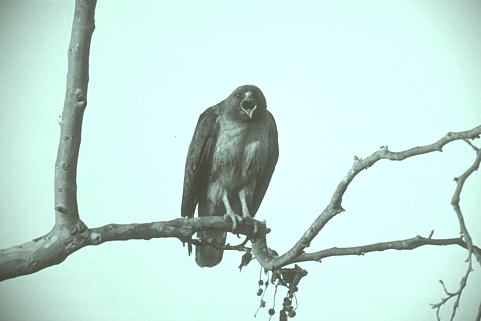

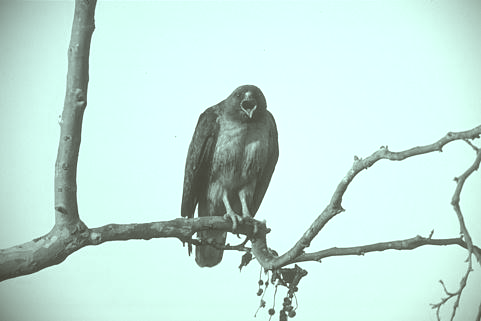

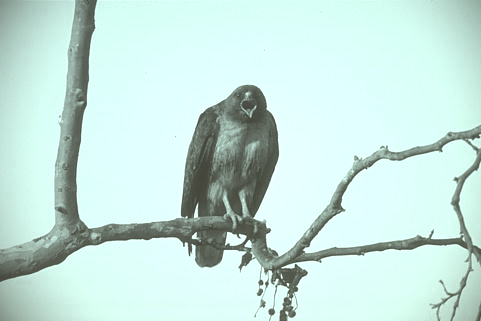

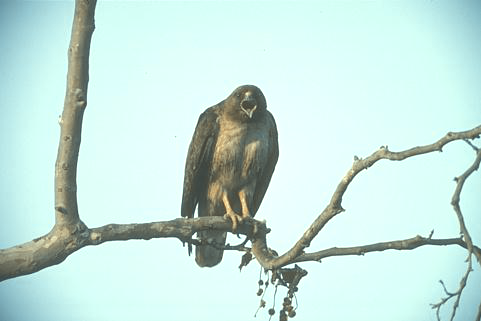

In [25]:
rezz = zeros(1, size(feature, 1))
rats = copy(rezz)
for dim=1:size(feature, 1)-1
    pca_mdl = fit(PCA, feature; maxoutdim=dim)
    rezz[dim] = tresidualvar(pca_mdl)
    rats[dim] = principalratio(pca_mdl)
    lossy = MultivariateStats.transform(pca_mdl, feature)
    estimate = reconstruct(pca_mdl, lossy)[3:5,:]
    #println(estimate[:,1])
    # undo z-score operation
    estimate = estimate .* σ[3:5] + (ones(size(estimate, 2), 1) * μ[3:5]')'
    display(reshape(colorview(RGB, estimate), nc, nr)')
end

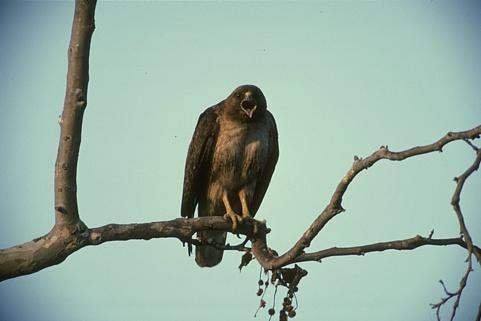

In [26]:
data

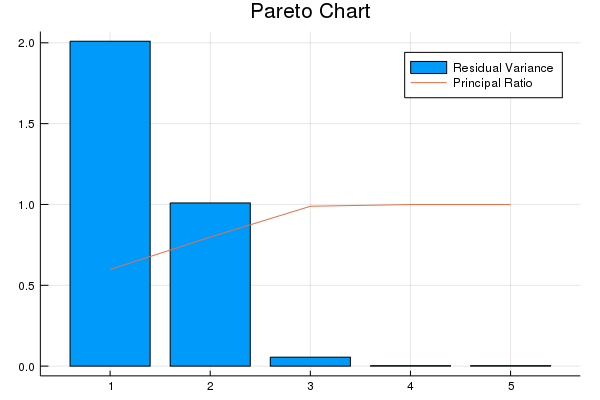

In [12]:
#theme(:juno)
bar(rezz', label="Residual Variance", title="Pareto Chart", fmt=:png)
plot!(rats', label="Principal Ratio", fmt=:png)

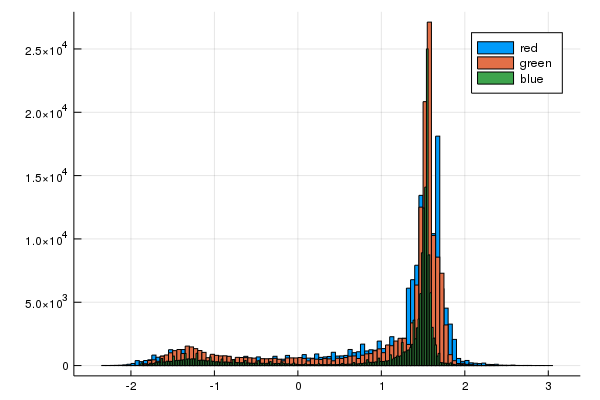

In [13]:
histogram(feature[3,:], labels="red", fmt=:png)
histogram!(feature[4,:], labels="green")
histogram!(feature[5,:], labels="blue")

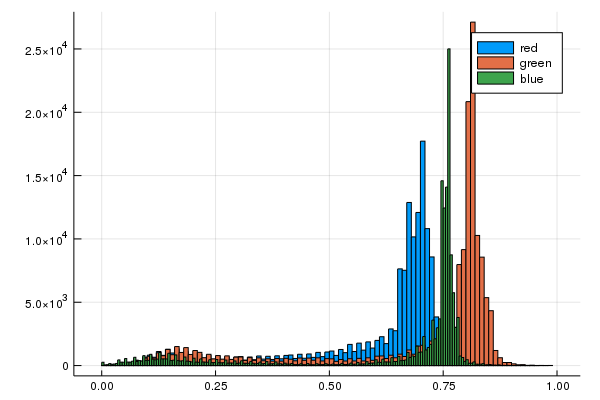

In [14]:
histogram(raw_feature'[3,:], labels="red", fmt=:png)
histogram!(raw_feature'[4,:], labels="green")
histogram!(raw_feature'[5,:], labels="blue")

## Mean Shift Clustering

Visualize first 3 PCA components as colors

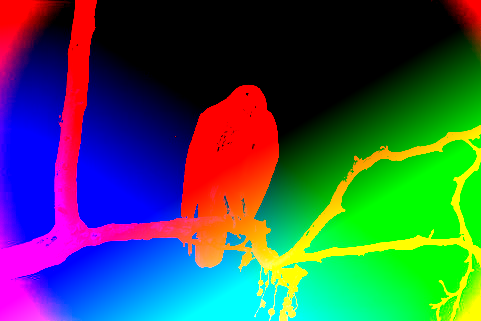

In [212]:
pca_pix = colorview(RGB, pca_feat[1:3, :]);
dims = size(data)
pca_img = copy(reshape(pca_pix, dims[2], dims[1])')

Sample from PCA features

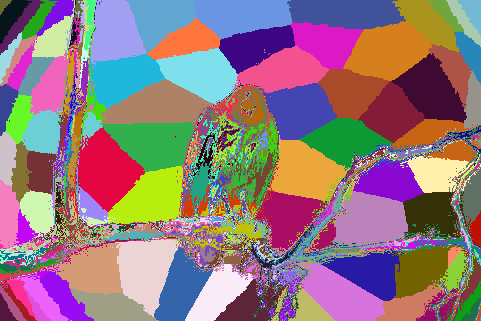

nothing

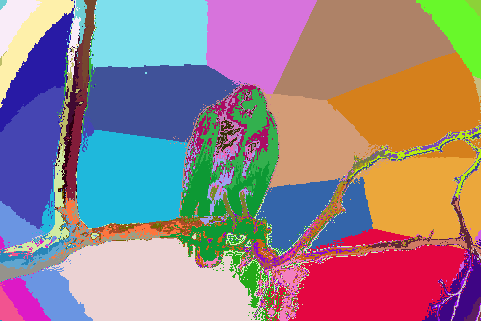

nothing

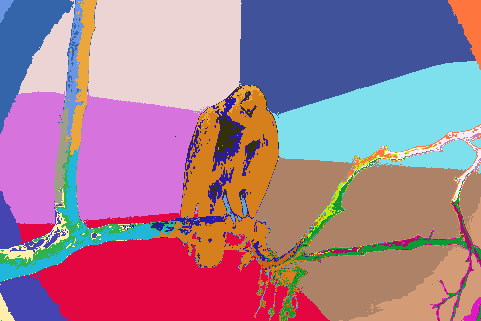

nothing

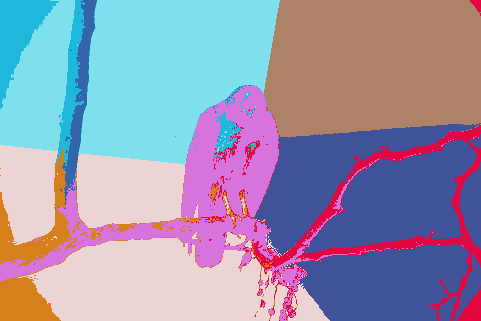

nothing

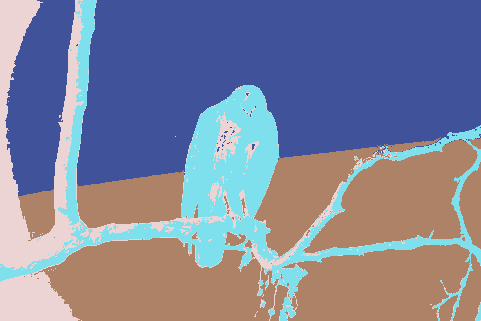

nothing

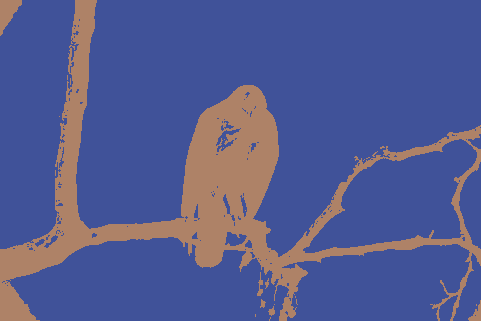

nothing

In [17]:
bws = collect(0.25:0.25:1.5);
samples = 5;
num_clusters = zeros(size(bws, 1), samples)
for bw_iter=1:size(bws, 1)
    bw = bws[bw_iter]
    for sample=1:samples
        pct_sample = 0.01
        nsamps = convert(Int, round(size(pca_feat)[2]*pct_sample))
        idxs = rand(1:size(pca_feat)[2], nsamps)
        pca_samps = copy(pca_feat[:,idxs])';
        #bw = estimate_bandwidth(pca_samps, quantile=0.2)
        #println("Bandwidth: $bw, sample: $sample")
        ms = fit!(MeanShift(bandwidth=bw, bin_seeding=true), pca_samps);
        labels = ms.predict(pca_feat');
        # Add 1 because it's zero indexed
        nclust = maximum(labels) + 1
        num_clusters[bw_iter, sample] = nclust
        if sample == 1
            display(labels_to_color_image(labels, nc, nr))
        end
    end
end

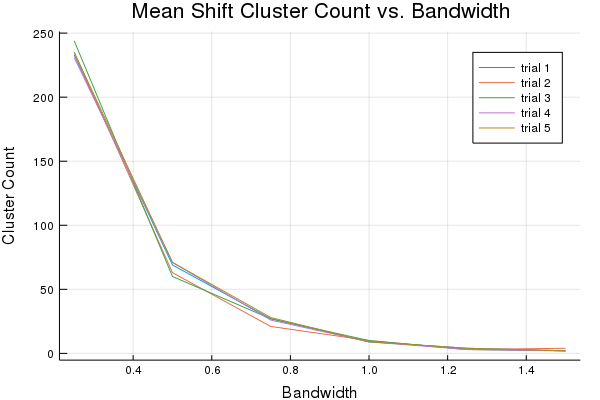

In [18]:
labels = ["trial $i" for i=1:samples]
plot(bws, num_clusters, labels=labels; xlabel="Bandwidth", ylabel="Cluster Count", title="Mean Shift Cluster Count vs. Bandwidth", fmt=:png )

In [20]:
estimate_bandwidth(pca_samps, quantile=0.2)

UndefVarError: UndefVarError: pca_samps not defined

In the figure above, the cluster count is plotted against the bandwidth for 5 separate trials of the mean shift algorithm. From this plot, it is clear that a larger bandwidth leads to a smaller number of final clusters. This makes sense, given that a larger bandwidth would mean clusters have more pull, and would then more quickly absorb neighboring points. Overall, the final number of clusters stays fairly consistent for different data samples within a given bandwidth. The actual regions being selected change from sample to sample however, especially when the percent of pixels being sampled is low. For this particular image, 2 clusters is enough to get a rough idea of what is happening. As the branch has many colors and stretches across space, linear PCA will do a bad job separating this numerically. A larger number of clusters in Mean Shift will not separate the bird from the tree. With this in mind, adding more clusters is not helpful from a semantic perspective. This is consistent with Julia's internal bandwidth estimation tool, which says that a bandwidth of 1.7 is optimal for this image, which leads to 2 clusters.

## K Means Clustering

┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = _kmeans!(::Array{Float64,2}, ::Nothing, ::Array{Float64,2}, ::Array{Int64,1}, ::Array{Float64,1}, ::Array{Int64,1}, ::Array{Float64,1}, ::Int64, ::Float64, ::Int64, ::SqEuclidean) at kmeans.jl:118
└ @ Clustering /home/zach/.julia/packages/Clustering/bh5ie/src/kmeans.jl:118


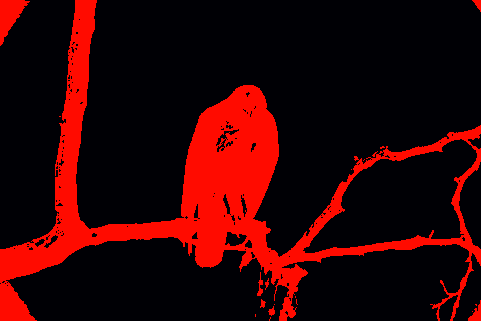

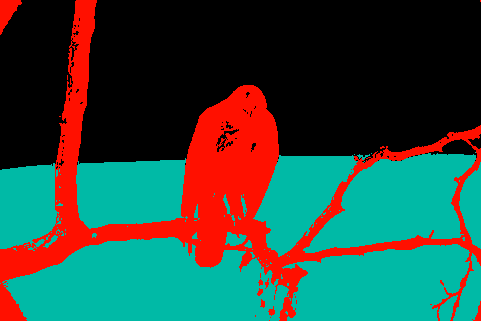

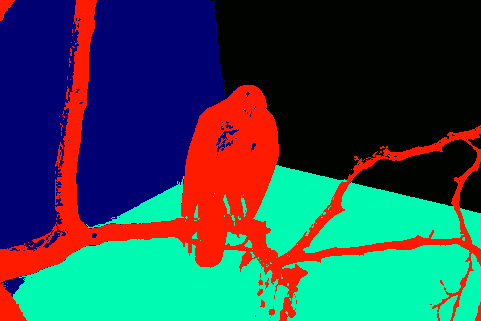

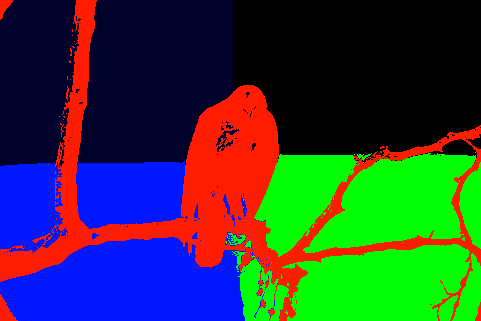

In [161]:
for j=2:5
    R = kmeans(pca_feat, j; maxiter=500);
    as = copy(assignments(R));
    colors = map(i->colorview(RGB,R.centers)[i], as);
    display(reshape(colors, nc, nr)')
end

## GMM

This GMM library uses KMeans to set initial means for EM. I have set the number of iterations of kmeans to 0, so the initial means are random as the assignment specifies.

┌ Info: Initializing GMM, 2 Gaussians LinearAlgebra.diag covariance 3 dimensions using 154401 data points
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:77


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       6.447724e+03
K-means terminated without convergence after 0 iterations (objv = 6447.724378666297)


┌ Info: K-means with 2000 data points using 0 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:138
┌ Info: Running 10 iterations EM on full cov GMM with 2 Gaussians in 3 dimensions
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:242
┌ Info: iteration 1, average log likelihood -1.611826
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 2, average log likelihood -1.367009
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 3, average log likelihood -1.348819
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 4, average log likelihood -1.335045
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 5, average log likelihood -1.324180
└ @ GaussianMixtures /home/zach/.juli

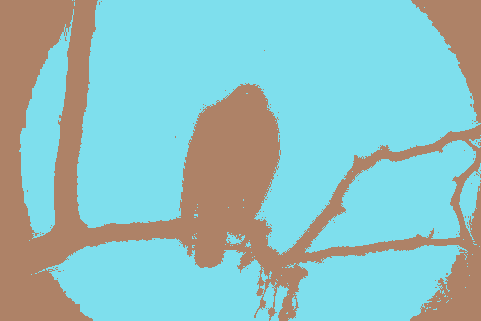

┌ Info: EM with 154401 data points 10 iterations avll -1.294941
│ 8126.4 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: Initializing GMM, 3 Gaussians LinearAlgebra.diag covariance 3 dimensions using 154401 data points
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:77


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       8.947260e+03
K-means terminated without convergence after 0 iterations (objv = 8947.260175681615)


┌ Info: K-means with 3000 data points using 0 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:138
┌ Info: Running 10 iterations EM on full cov GMM with 3 Gaussians in 3 dimensions
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:242
┌ Info: iteration 1, average log likelihood -1.746985
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 2, average log likelihood -1.277587
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 3, average log likelihood -1.260762
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 4, average log likelihood -1.249387
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 5, average log likelihood -1.239984
└ @ GaussianMixtures /home/zach/.juli

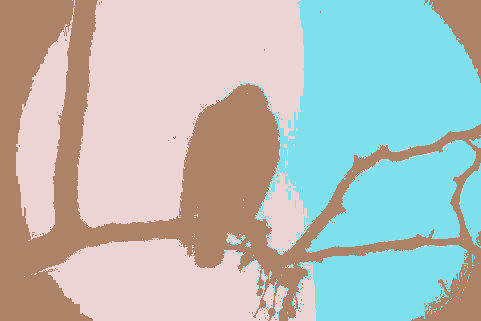

┌ Info: EM with 154401 data points 10 iterations avll -1.206761
│ 5324.2 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: Initializing GMM, 4 Gaussians LinearAlgebra.diag covariance 3 dimensions using 154401 data points
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:77


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       7.398851e+03
K-means terminated without convergence after 0 iterations (objv = 7398.850950029998)


┌ Info: K-means with 4000 data points using 0 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:138
┌ Info: Running 10 iterations EM on full cov GMM with 4 Gaussians in 3 dimensions
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:242
┌ Info: iteration 1, average log likelihood -1.427555
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 2, average log likelihood -1.261871
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 3, average log likelihood -1.230099
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 4, average log likelihood -1.205422
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 5, average log likelihood -1.188866
└ @ GaussianMixtures /home/zach/.juli

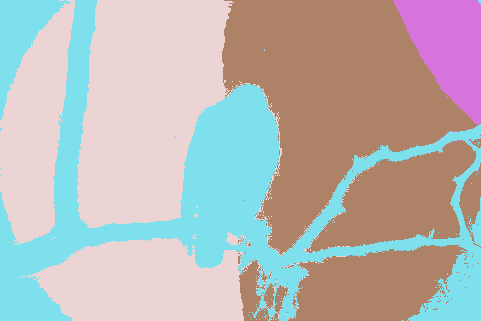

┌ Info: EM with 154401 data points 10 iterations avll -1.164814
│ 3959.0 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: Initializing GMM, 5 Gaussians LinearAlgebra.diag covariance 3 dimensions using 154401 data points
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:77


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       9.806407e+03
K-means terminated without convergence after 0 iterations (objv = 9806.40677965699)


┌ Info: K-means with 5000 data points using 0 iterations
│ 250.0 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:138
┌ Info: Running 10 iterations EM on full cov GMM with 5 Gaussians in 3 dimensions
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/train.jl:242
┌ Info: iteration 1, average log likelihood -1.627985
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 2, average log likelihood -1.231867
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 3, average log likelihood -1.185733
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 4, average log likelihood -1.160236
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71
┌ Info: iteration 5, average log likelihood -1.145734
└ @ GaussianMixtures /home/zach/.juli

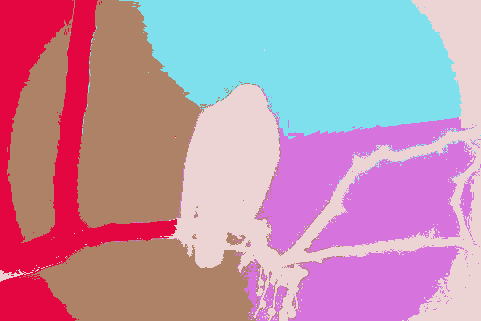

┌ Info: EM with 154401 data points 10 iterations avll -1.103051
│ 3151.0 data points per parameter
└ @ GaussianMixtures /home/zach/.julia/packages/GaussianMixtures/RGtTJ/src/gmms.jl:71


In [162]:
for j=2:5
    gmm_mdl = GMM(j, copy(pca_feat'); method=:kmeans, kind=:full, nInit=0, nIter=10, nFinal=10);
    preds = ScikitLearn.predict(gmm_mdl, copy(pca_feat'));
    labels_to_color_image(preds, nc, nr)
end